**This notebook was designed to be run on Google Collab.**

In this notebook we present the results of our work around Cycle GANs as part of the Deep Learning course taught at ENSAE by Marco Cuturi (2021 class). We will implement a CycleGAN architecture in order to translate from the MNIST dataset to the USPS dataset. We follow Roger Grosse's detailed assignment (handout and base code can be found [here](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/assignments/assignment4.pdf) and [here](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/assignments/a4-code.zip)). 

# 0 - Packages

In [ ]:
# image imports
import imageio
from PIL import Image

# file management imports
import pathlib
import os
import pdb
import pickle

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *

# Numpy & Scipy imports
import numpy as np
import scipy
import scipy.misc

# Misc
import matplotlib.pyplot as plt
import argparse

# I - Prerequisite

### 1) Hyper-parameters of the models
First, we create a parser where we define all the required parameters to train the models.

In [ ]:
#Definition of the parser of the whole parameters
def create_parser():
    parser = argparse.ArgumentParser()

    # Model hyper-parameters
    parser.add_argument('--image_size', type=int, default=28, help='The side length N to convert images to NxN.')
    parser.add_argument('--g_conv_dim', type=int, default=64)
    parser.add_argument('--d_conv_dim', type=int, default=64)
    parser.add_argument('--use_cycle_consistency_loss', action='store_true', default=True, help='Choose whether to include the cycle consistency term in the loss.')
    parser.add_argument('--init_zero_weights', action='store_true', default=False, help='Choose whether to initialize the generator conv weights to 0 (implements the identity function).')

    # Training hyper-parameters
    parser.add_argument('--train_iters', type=int, default=600, help='The number of training iterations to run')
    parser.add_argument('--batch_size', type=int, default=16, help='The number of images in a batch.')
    parser.add_argument('--num_workers', type=int, default=0, help='The number of threads to use for the DataLoader.')
    parser.add_argument('--lr', type=float, default=0.0003, help='The learning rate (default 0.0003)')
    
    ## Adam optimizer parameters
    parser.add_argument('--beta1', type=float, default=0.5)
    parser.add_argument('--beta2', type=float, default=0.999)
  
    # Saving directories and checkpoint/sample iterations
    parser.add_argument('--checkpoint_dir', type=str, default='checkpoints_cyclegan')
    parser.add_argument('--sample_dir', type=str, default='samples_cyclegan')
    parser.add_argument('--load', type=str, default=None)
    
    # timerange between prints of information
    parser.add_argument('--log_step', type=int , default=10)
    parser.add_argument('--sample_every', type=int , default=100)
    parser.add_argument('--checkpoint_every', type=int , default=200)

    # Define the lambda of the Cycle Consistency loss
    parser.add_argument('--CClambda', type=int , default=10)

    return parser

#Print the current parameters
def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        if opts.__dict__[key]:
            print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)

In [ ]:
parser=create_parser()
opts,_ = parser.parse_known_args()
print_opts(opts)

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 28                                     
                             g_conv_dim: 64                                     
                             d_conv_dim: 64                                     
             use_cycle_consistency_loss: 1                                      
                            train_iters: 600                                    
                             batch_size: 16                                     
                                     lr: 0.0003                                 
                                  beta1: 0.5                                    
                                  beta2: 0.999                                  
                         checkpoint_dir: checkpoints_cyclegan                   
                            

### 2) Importing data
In this section, we importe the USPS and MNIST data. We resize the USPS images to get the same image size for the two datasets.


Dimensions of the inputs are torch.Size([16, 1, 28, 28])
The number on the image is: 4


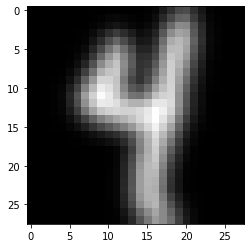

In [ ]:
# We split the whole train set in two parts:
# the one that we actually use for training
# and the one that we use for validation

# We download the oficial USPS train set and resize it to 28
my_transform = transforms.Compose([Resize(28), ToTensor()])
train_USPS = datasets.USPS('data/',
                           download=True,
                           train=True,
                           transform=my_transform)

test_USPS = datasets.USPS('data/',
                           download=True,
                           train=False,
                           transform=my_transform)

#Creation of dataloader with batches for the training and validation rounds
trainloader_USPS = torch.utils.data.DataLoader(train_USPS,batch_size=opts.batch_size,shuffle=True)
valloader_USPS = torch.utils.data.DataLoader(test_USPS,batch_size=opts.batch_size,shuffle=True)

# We print a random image from the USPS dataset
for inputs, targets in trainloader_USPS:
    print(f'Dimensions of the inputs are {inputs.shape}')
    plt.imshow(inputs[0][0], cmap='gray', interpolation='none')
    print(f'The number on the image is: {targets[0]}')
    break

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dimensions of the inputs are torch.Size([16, 1, 28, 28])
The number on the image is: 9


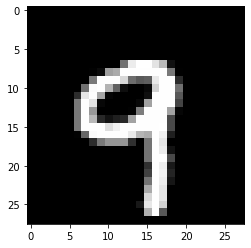

In [ ]:
# We split the whole train set in two parts:
# the one that we actually use for training
# and the one that we use for validation

# We download the oficial MNIST train set
train_MNIST = datasets.MNIST('data/',
                           download=True,
                           train=True,
                           transform=transforms.ToTensor())

test_MNIST = datasets.MNIST('data/',
                           download=True,
                           train=False,
                           transform=transforms.ToTensor())

#Creation of dataloader with batches for the training and validation rounds
trainloader_MNIST = torch.utils.data.DataLoader(train_MNIST, batch_size=opts.batch_size, shuffle=True)
valloader_MNIST = torch.utils.data.DataLoader(test_MNIST, batch_size=opts.batch_size, shuffle=True)

# We print a random image from the MNIST dataset
for inputs, targets in trainloader_MNIST:
    print(f'Dimensions of the inputs are {inputs.shape}')
    plt.imshow(inputs[0][0], cmap='gray', interpolation='none')
    print(f'The number on the image is: {targets[0]}')
    break

We notice that MNIST images have a better quality resolution than USPS images. The goal of the following sections will be to use a Cycle-GAN to increase or decrease the resolution of the images quality.

# II - Implementation of the Cycle-GAN architecture

### 1) Generator

Both generators $G : X\rightarrow Y$ and $F:Y\rightarrow X$ have the same structure and can be divided into three main blocks. 
- The first stage encodes the input via a series of convolutional features that extract the image features. 
- Then, the second stage transforms the features by passing them through one or more residual blocks. These residual blocks consist of a convolutional layer where the input is added to the output of the convolution. This is done so that the characteristics of the output do not differ too much from the input. 
- Finally, in the third stage the transformed features are decoded using a series of transposed convolutional layers and an output image (same size as the input) is produced.

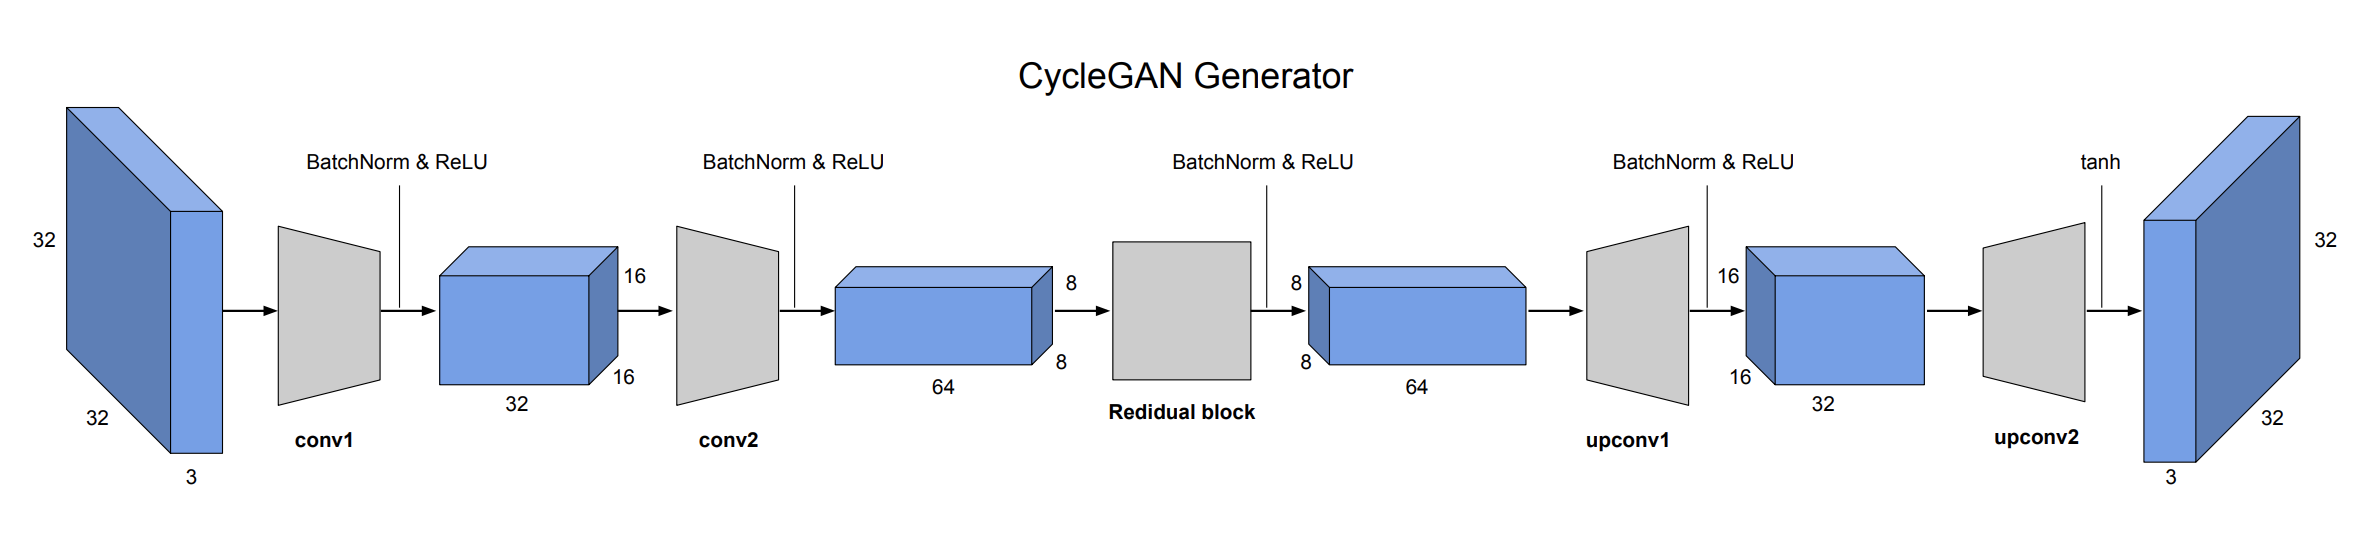

First of all, we define three functions useful for both the generator and the discriminator: the deconvolution block, the convolution block and the resnet block.

In [ ]:
#Deconvolution neural networks
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    #If option is chosen, normalization layer applied on the batches is added
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


#Convolution neural networks
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, init_zero_weights=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    #If option is chosen, the inital weights are set to almost zero
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
    layers.append(conv_layer)

    #If option is chosen, normalization layer applied on the batches is added
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

#Resnet Block
class ResnetBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResnetBlock, self).__init__()
        self.conv_layer = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = x + self.conv_layer(x)
        return out


Then, we build the cycle-generator.

In [ ]:
class CycleGenerator(nn.Module):
    """Defines the architecture of the generator network.
       Note: Both generators G_XtoY and G_YtoX have the same architecture in this assignment.
    """
    def __init__(self, conv_dim=64, init_zero_weights=False):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator (that extracts features from the input image)
        self.conv1 = conv(in_channels=1,out_channels=32,kernel_size=(4,4),stride=2,padding=1,batch_norm=True,init_zero_weights=False)
        self.conv2 = conv(in_channels=32,out_channels=conv_dim,kernel_size=(4,4),stride=2,padding=1,batch_norm=True,init_zero_weights=False)
        
        # 2. Define the transformation part of the generator
        self.resnet_block = ResnetBlock(conv_dim=conv_dim)

        # 3. Define the decoder part of the generator (that builds up the output image from features)
        self.deconv1 = deconv(in_channels=conv_dim, out_channels=32, kernel_size=(4,4), stride=2, padding=1, batch_norm=True)
        self.deconv2 = deconv(in_channels=32, out_channels=1, kernel_size=(4,4), stride=2, padding=1, batch_norm=True)

    def forward(self, x):
        """Generates an image conditioned on an input image.
            Input
            -----
                x: BS x 1 x 28 x 28
            Output
            ------
                out: BS x 1 x 28 x 28
        """

        out = torch.nn.functional.relu(self.conv1(x))
        out = torch.nn.functional.relu(self.conv2(out))

        out = torch.nn.functional.relu(self.resnet_block(out))

        out = torch.nn.functional.relu(self.deconv1(out))
        out = torch.nn.functional.tanh(self.deconv2(out))

        return out

In [ ]:
#Instanciate the cycle-generator
model_generator=CycleGenerator()

To verify that the generator gives an image, we generate a random image with the generator.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([16, 1, 28, 28])


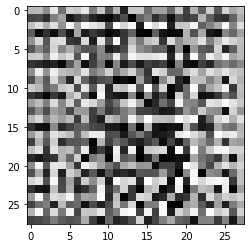

In [ ]:
for inputs, targets in trainloader_USPS:
    y=model_generator(inputs)
    with torch.no_grad():
      plt.imshow(y[0][0], cmap='gray', interpolation='none')
    print(y.shape)
    break

### 2) Discriminator
We now define the  Deep Convolutional Generative (DCG) discriminator which will be  the discriminator of the Cycle-Gan.

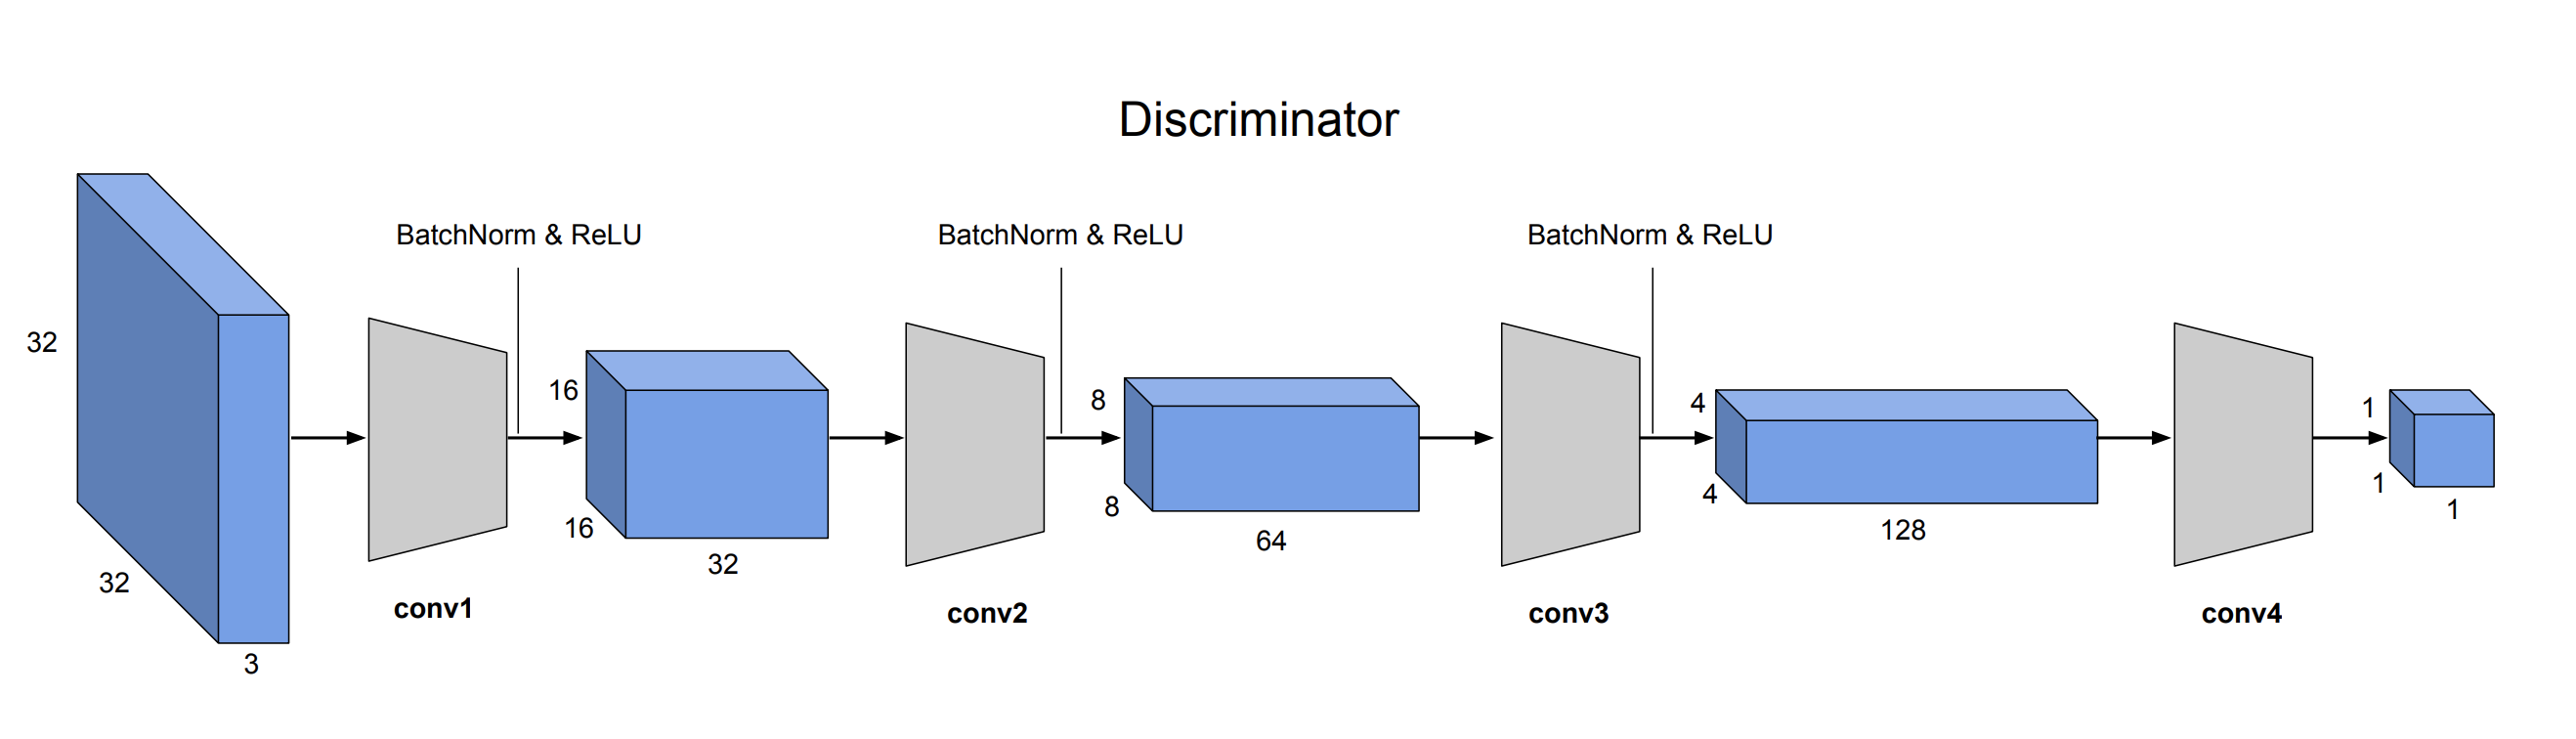

In [ ]:
class DCDiscriminator(nn.Module):
    """Defines the architecture of the discriminator network.
    """
    def __init__(self, conv_dim=64):
        super(DCDiscriminator, self).__init__()

        # Define the encoder part of the discriminator (that extracts features from the input image)
        self.conv1 = conv(in_channels=1,out_channels=32,kernel_size=(4,4),stride=2,padding=1,batch_norm=True,init_zero_weights=False)
        self.conv2 = conv(in_channels=32,out_channels=64,kernel_size=(4,4),stride=2,padding=1,batch_norm=True,init_zero_weights=False)
        self.conv3 = conv(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1,batch_norm=True,init_zero_weights=False)
        self.conv4 = conv(in_channels=128,out_channels=1,kernel_size=(3,3),stride=4,padding=0,batch_norm=False,init_zero_weights=False)

    def forward(self, x):

        out = torch.nn.functional.relu(self.conv1(x))
        out = torch.nn.functional.relu(self.conv2(out))
        out = torch.nn.functional.relu(self.conv3(out))

        out = self.conv4(out).squeeze()
        #Apply a sigmoid function on the last layer to get a unique output
        out = torch.nn.functional.sigmoid(out)
        return out

In [ ]:
#Instantiate the cycle-discriminator
model_discriminator=DCDiscriminator()

To verify that the DCG-discriminator gives a good output, we apply it on a random image. We obtain one score for each element of the batch. 

In [ ]:
for inputs, targets in trainloader_USPS:
    y=model_discriminator(inputs)
    print(y)
    break

tensor([0.3799, 0.4323, 0.4841, 0.3714, 0.4580, 0.4446, 0.4264, 0.4380, 0.4597,
        0.4728, 0.4513, 0.4856, 0.4634, 0.3719, 0.4461, 0.4108],
       grad_fn=<SigmoidBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# III - Training

### 1) Definition of all of the useful functions for the training

In [ ]:
import os

import torch
from torch.autograd import Variable

'''This function will be used to properly convert images/labels in the training loop '''
def to_var(x):
    """Converts numpy to variable."""
    #If GPU is activated we migrate the data into a cuda device
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def to_data(x):
    """Converts variable to numpy."""
    #If GPU is activated we migrate the data from the cuda device to get the numpy data
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

def create_dir(directory):
    """Creates a directory if it does not already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

#we instantiate a L1 loss (used for cycle consistency)
l1_loss = torch.nn.L1Loss() 

In [ ]:
#function to create all the required generators and discriminators used in the cycle-gan
def create_model(opts):
    """Builds the generators and discriminators.
    """
    #Generator- generate an image from X to Y
    G_XtoY = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    #Generator- generate an image from Y to X
    G_YtoX = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    #Discriminator of the X images
    D_X = DCDiscriminator(conv_dim=opts.d_conv_dim)
    #Discriminator of the Y images
    D_Y = DCDiscriminator(conv_dim=opts.d_conv_dim)

    print_models(G_XtoY, G_YtoX, D_X, D_Y)

    #If GPU is activated we migrate the functions into a cuda device
    if torch.cuda.is_available():
        G_XtoY.cuda()
        G_YtoX.cuda()
        D_X.cuda()
        D_Y.cuda()
        print('Models moved to GPU.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                 G_XtoY                ")
    print("---------------------------------------")
    print(G_XtoY)
    print("---------------------------------------")

    print("                 G_YtoX                ")
    print("---------------------------------------")
    print(G_YtoX)
    print("---------------------------------------")

    print("                  D_X                  ")
    print("---------------------------------------")
    print(D_X)
    print("---------------------------------------")

    print("                  D_Y                  ")
    print("---------------------------------------")
    print(D_Y)
    print("---------------------------------------")

In [ ]:
def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, opts):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
    """
    #Define the paths to save the generators and discriminators parameters
    G_XtoY_path = os.path.join(opts.checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(opts.checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(opts.checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(opts.checkpoint_dir, 'D_Y.pkl')

    #Save the current trained weights of the generators and discriminators
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def load_checkpoint(opts):
    """Loads the generator and discriminator models from checkpoints.
    """

    #Define the paths whare the generators and discriminators parameters are saved
    G_XtoY_path = os.path.join(opts.load, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(opts.load, 'G_YtoX.pkl')
    D_X_path = os.path.join(opts.load, 'D_X.pkl')
    D_Y_path = os.path.join(opts.load, 'D_Y.pkl')

    #We re-define the architectures of the generators and discriminators
    G_XtoY = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    G_YtoX = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    D_X = DCDiscriminator(conv_dim=opts.d_conv_dim)
    D_Y = DCDiscriminator(conv_dim=opts.d_conv_dim)

    #We load the weights of the pre-trained generators and discriminators
    G_XtoY.load_state_dict(torch.load(G_XtoY_path, map_location=lambda storage, loc: storage))
    G_YtoX.load_state_dict(torch.load(G_YtoX_path, map_location=lambda storage, loc: storage))
    D_X.load_state_dict(torch.load(D_X_path, map_location=lambda storage, loc: storage))
    D_Y.load_state_dict(torch.load(D_Y_path, map_location=lambda storage, loc: storage))

    #If GPU is activated we migrate the functions into a cuda device
    if torch.cuda.is_available():
        G_XtoY.cuda()
        G_YtoX.cuda()
        D_X.cuda()
        D_Y.cuda()
        print('Models moved to GPU.')

    return G_XtoY, G_YtoX, D_X, D_Y

def merge_images(sources, targets, opts, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    row = int(np.sqrt(opts.batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    #We merge the images for the final vizualisation
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)


def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, opts):
    """Saves samples from both generators X->Y and Y->X.
    """
    #Create the fake fixed images through the current generators
    fake_X = G_YtoX(fixed_Y)
    fake_Y = G_XtoY(fixed_X)

    #Move from torch data to numpy
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)

    #Create the image for visualization for X and save it
    merged = merge_images(X, fake_Y, opts)
    path = os.path.join(opts.sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    #Create the image for visualization for Y and save it
    merged = merge_images(Y, fake_X, opts)
    path = os.path.join(opts.sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))


### 2) Definition of the training

In [ ]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    # Create generators and discriminators
    if opts.load:
        G_XtoY, G_YtoX, D_X, D_Y = load_checkpoint(opts)
    else:
        G_XtoY, G_YtoX, D_X, D_Y = create_model(opts)

    # we concatenate the parameters of the two generators (resp two discriminators)
    g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters
    d_params = list(D_X.parameters()) + list(D_Y.parameters())  # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
    d_optimizer = optim.Adam(d_params, opts.lr, [opts.beta1, opts.beta2])

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = to_var(test_iter_X.next()[0])
    fixed_Y = to_var(test_iter_Y.next()[0])

    # the nb of iterations per epoch is equal to the number of batches in the smaller dataset (MNIST or USPS)
    iter_per_epoch = min(len(iter_X), len(iter_Y))

    for iteration in range(1, opts.train_iters+1):

        # Reset data_iter for each epoch
        # Every time the model has iterated over every batch we reinitialize the iterator and start another epoch on all the batches
        if iteration % iter_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, labels_X = iter_X.next()
        images_X, labels_X = to_var(images_X), to_var(labels_X).long().squeeze()

        images_Y, labels_Y = iter_Y.next()
        images_Y, labels_Y = to_var(images_Y), to_var(labels_Y).long().squeeze()


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        # Train with real images
        d_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        D_X_loss = torch.mean((D_X(images_X)-1)**2)
        D_Y_loss = torch.mean((D_Y(images_Y)-1)**2)
       
        d_real_loss = D_X_loss + D_Y_loss
        d_real_loss.backward()
        d_optimizer.step()

        # Train with fake images
        d_optimizer.zero_grad()

        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the loss for D_X
        D_X_loss = torch.mean((D_X(fake_X))**2)

        # 4. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 5. Compute the loss for D_Y
        D_Y_loss = torch.mean((D_Y(fake_Y))**2)

        d_fake_loss = D_X_loss + D_Y_loss
        d_fake_loss.backward()
        d_optimizer.step()



        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================


        #########################################
        ##   Y--X-->Y CYCLE     ##
        #########################################
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        g_loss = torch.mean((D_X(fake_X)-1)**2)

        if opts.use_cycle_consistency_loss:
            reconstructed_Y = G_XtoY(fake_X)
            # 3. Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = l1_loss(images_Y,reconstructed_Y)*opts.CClambda 
            g_loss += cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()



        #########################################
        ##   X--Y-->X CYCLE     ##
        #########################################
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        g_loss = torch.mean((D_Y(fake_Y)-1)**2)

        if opts.use_cycle_consistency_loss:
            reconstructed_X = G_YtoX(fake_Y)
            # 3. Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = l1_loss(images_X,G_YtoX(fake_Y))*opts.CClambda 
            g_loss += cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()


        # Print the log info
        if iteration % opts.log_step == 0:
            print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_Y_loss: {:6.4f} | d_X_loss: {:6.4f} | '
                  'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    iteration, opts.train_iters, d_real_loss.item(), D_Y_loss.item(),
                    D_X_loss.item(), d_fake_loss.item(), g_loss.item()))


        # Save the generated samples every 100 iterations to check our performance qualitatively
        if iteration % opts.sample_every == 0:
            save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, opts)


        # Save the model parameters
        if iteration % opts.checkpoint_every == 0:
            checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, opts)


Finally, we define the main function which will launch the training

In [ ]:
def main(opts):
    """Loads the data, creates checkpoint and sample directories, and starts the training loop.
    """

    # Create train and test dataloaders for images from the two domains X and Y
    trainloader_MNIST = torch.utils.data.DataLoader(train_MNIST, batch_size=opts.batch_size, shuffle=True)
    valloader_MNIST = torch.utils.data.DataLoader(test_MNIST, batch_size=opts.batch_size, shuffle=True)
    trainloader_USPS = torch.utils.data.DataLoader(train_USPS, batch_size=opts.batch_size, shuffle=True)
    valloader_USPS = torch.utils.data.DataLoader(test_USPS, batch_size=opts.batch_size, shuffle=True)
    

    # Create checkpoint and sample directories
    create_dir(opts.checkpoint_dir)
    create_dir(opts.sample_dir)

    # Start training
    training_loop(trainloader_MNIST,trainloader_USPS, valloader_MNIST, valloader_USPS, opts)

# IV) - Cycle-GAN Experiments
In this part, we will try different experiments. In the two first ones, we launch the training with different random seeds. Then we will vary the lambda parameter of the cycle-consistency loss.

## 1) Baseline exemple 

We start by training our model on 10 000 iterations with a random-seed of 11. 

In [ ]:
SEED = 11

# Set the random seed manually 
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [ ]:
#We re-define some hyper-parameters of the parser
opts.use_cycle_consistency_loss = True #To use the cycle-consistency loss
opts.sample_dir = 'question1_samples_cyclegan' #The direction to save the generated images by the cycle-gan
opts.train_iters = 10000 #Number of training iterations
opts.checkpoint_dir = 'question1_checkpoint_cyclegan' #The direction to save the weights of the cycle-gan
opts.log_step = 500 #The number of iterations required to print the losses of the generators and discriminators for the current iteration
opts.sample_every = 200 #The number of iterations required to create the images for the visualization
opts.checkpoint_every = 2000 #The number of iterations required tos ave the weights of the cycle-gan
print_opts(opts)

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 28                                     
                             g_conv_dim: 64                                     
                             d_conv_dim: 64                                     
             use_cycle_consistency_loss: 1                                      
                            train_iters: 10000                                  
                             batch_size: 16                                     
                                     lr: 0.0003                                 
                                  beta1: 0.5                                    
                                  beta2: 0.999                                  
                         checkpoint_dir: question1_checkpoint_cyclegan          
                            

In [ ]:
main(opts)

                 G_XtoY                
---------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resnet_block): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Saved question1_samples_cyclegan/sample-000200-X-Y.png
Saved question1_samples_cyclegan/sample-000200-Y-X.png


Saved question1_samples_cyclegan/sample-000400-X-Y.png
Saved question1_samples_cyclegan/sample-000400-Y-X.png
Iteration [  500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.5808


Saved question1_samples_cyclegan/sample-000600-X-Y.png
Saved question1_samples_cyclegan/sample-000600-Y-X.png


Saved question1_samples_cyclegan/sample-000800-X-Y.png
Saved question1_samples_cyclegan/sample-000800-Y-X.png


Iteration [ 1000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 1.4242
Saved question1_samples_cyclegan/sample-001000-X-Y.png
Saved question1_samples_cyclegan/sample-001000-Y-X.png


Saved question1_samples_cyclegan/sample-001200-X-Y.png
Saved question1_samples_cyclegan/sample-001200-Y-X.png


Saved question1_samples_cyclegan/sample-001400-X-Y.png
Saved question1_samples_cyclegan/sample-001400-Y-X.png
Iteration [ 1500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.4361


Saved question1_samples_cyclegan/sample-001600-X-Y.png
Saved question1_samples_cyclegan/sample-001600-Y-X.png


Saved question1_samples_cyclegan/sample-001800-X-Y.png
Saved question1_samples_cyclegan/sample-001800-Y-X.png


Iteration [ 2000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.3852
Saved question1_samples_cyclegan/sample-002000-X-Y.png
Saved question1_samples_cyclegan/sample-002000-Y-X.png


Saved question1_samples_cyclegan/sample-002200-X-Y.png
Saved question1_samples_cyclegan/sample-002200-Y-X.png


Saved question1_samples_cyclegan/sample-002400-X-Y.png
Saved question1_samples_cyclegan/sample-002400-Y-X.png
Iteration [ 2500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.3186


Saved question1_samples_cyclegan/sample-002600-X-Y.png
Saved question1_samples_cyclegan/sample-002600-Y-X.png


Saved question1_samples_cyclegan/sample-002800-X-Y.png
Saved question1_samples_cyclegan/sample-002800-Y-X.png


Iteration [ 3000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.3120
Saved question1_samples_cyclegan/sample-003000-X-Y.png
Saved question1_samples_cyclegan/sample-003000-Y-X.png


Saved question1_samples_cyclegan/sample-003200-X-Y.png
Saved question1_samples_cyclegan/sample-003200-Y-X.png


Saved question1_samples_cyclegan/sample-003400-X-Y.png
Saved question1_samples_cyclegan/sample-003400-Y-X.png
Iteration [ 3500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2359


Saved question1_samples_cyclegan/sample-003600-X-Y.png
Saved question1_samples_cyclegan/sample-003600-Y-X.png


Saved question1_samples_cyclegan/sample-003800-X-Y.png
Saved question1_samples_cyclegan/sample-003800-Y-X.png


Iteration [ 4000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.3192
Saved question1_samples_cyclegan/sample-004000-X-Y.png
Saved question1_samples_cyclegan/sample-004000-Y-X.png


Saved question1_samples_cyclegan/sample-004200-X-Y.png
Saved question1_samples_cyclegan/sample-004200-Y-X.png


Saved question1_samples_cyclegan/sample-004400-X-Y.png
Saved question1_samples_cyclegan/sample-004400-Y-X.png
Iteration [ 4500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2392


Saved question1_samples_cyclegan/sample-004600-X-Y.png
Saved question1_samples_cyclegan/sample-004600-Y-X.png


Saved question1_samples_cyclegan/sample-004800-X-Y.png
Saved question1_samples_cyclegan/sample-004800-Y-X.png


Iteration [ 5000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2814
Saved question1_samples_cyclegan/sample-005000-X-Y.png
Saved question1_samples_cyclegan/sample-005000-Y-X.png


Saved question1_samples_cyclegan/sample-005200-X-Y.png
Saved question1_samples_cyclegan/sample-005200-Y-X.png


Saved question1_samples_cyclegan/sample-005400-X-Y.png
Saved question1_samples_cyclegan/sample-005400-Y-X.png
Iteration [ 5500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.3002


Saved question1_samples_cyclegan/sample-005600-X-Y.png
Saved question1_samples_cyclegan/sample-005600-Y-X.png


Saved question1_samples_cyclegan/sample-005800-X-Y.png
Saved question1_samples_cyclegan/sample-005800-Y-X.png


Iteration [ 6000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1976
Saved question1_samples_cyclegan/sample-006000-X-Y.png
Saved question1_samples_cyclegan/sample-006000-Y-X.png


Saved question1_samples_cyclegan/sample-006200-X-Y.png
Saved question1_samples_cyclegan/sample-006200-Y-X.png


Saved question1_samples_cyclegan/sample-006400-X-Y.png
Saved question1_samples_cyclegan/sample-006400-Y-X.png
Iteration [ 6500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2477


Saved question1_samples_cyclegan/sample-006600-X-Y.png
Saved question1_samples_cyclegan/sample-006600-Y-X.png


Saved question1_samples_cyclegan/sample-006800-X-Y.png
Saved question1_samples_cyclegan/sample-006800-Y-X.png


Iteration [ 7000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2513
Saved question1_samples_cyclegan/sample-007000-X-Y.png
Saved question1_samples_cyclegan/sample-007000-Y-X.png


Saved question1_samples_cyclegan/sample-007200-X-Y.png
Saved question1_samples_cyclegan/sample-007200-Y-X.png


Saved question1_samples_cyclegan/sample-007400-X-Y.png
Saved question1_samples_cyclegan/sample-007400-Y-X.png
Iteration [ 7500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1786


Saved question1_samples_cyclegan/sample-007600-X-Y.png
Saved question1_samples_cyclegan/sample-007600-Y-X.png


Saved question1_samples_cyclegan/sample-007800-X-Y.png
Saved question1_samples_cyclegan/sample-007800-Y-X.png


Iteration [ 8000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1721
Saved question1_samples_cyclegan/sample-008000-X-Y.png
Saved question1_samples_cyclegan/sample-008000-Y-X.png


Saved question1_samples_cyclegan/sample-008200-X-Y.png
Saved question1_samples_cyclegan/sample-008200-Y-X.png


Saved question1_samples_cyclegan/sample-008400-X-Y.png
Saved question1_samples_cyclegan/sample-008400-Y-X.png
Iteration [ 8500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1597


Saved question1_samples_cyclegan/sample-008600-X-Y.png
Saved question1_samples_cyclegan/sample-008600-Y-X.png


Saved question1_samples_cyclegan/sample-008800-X-Y.png
Saved question1_samples_cyclegan/sample-008800-Y-X.png


Iteration [ 9000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2089
Saved question1_samples_cyclegan/sample-009000-X-Y.png
Saved question1_samples_cyclegan/sample-009000-Y-X.png


Saved question1_samples_cyclegan/sample-009200-X-Y.png
Saved question1_samples_cyclegan/sample-009200-Y-X.png


Saved question1_samples_cyclegan/sample-009400-X-Y.png
Saved question1_samples_cyclegan/sample-009400-Y-X.png
Iteration [ 9500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1661


Saved question1_samples_cyclegan/sample-009600-X-Y.png
Saved question1_samples_cyclegan/sample-009600-Y-X.png


Saved question1_samples_cyclegan/sample-009800-X-Y.png
Saved question1_samples_cyclegan/sample-009800-Y-X.png


Iteration [10000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1989
Saved question1_samples_cyclegan/sample-010000-X-Y.png
Saved question1_samples_cyclegan/sample-010000-Y-X.png


## 2) Changing the random-seed

We change the random seed (to 10) and train the CycleGAN again

In [ ]:
SEED = 10
# Set the random seed manually 
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [ ]:
opts.use_cycle_consistency_loss = True
opts.sample_dir = 'question2_samples_cyclegan'
opts.train_iters = 10000
opts.checkpoint_dir = 'question2_checkpoint_cyclegan'
opts.log_step = 500
opts.sample_every = 200
opts.checkpoint_every = 2000
print_opts(opts)

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 28                                     
                             g_conv_dim: 64                                     
                             d_conv_dim: 64                                     
             use_cycle_consistency_loss: 1                                      
                            train_iters: 10000                                  
                             batch_size: 16                                     
                                     lr: 0.0003                                 
                                  beta1: 0.5                                    
                                  beta2: 0.999                                  
                         checkpoint_dir: question2_checkpoint_cyclegan          
                            

In [ ]:
main(opts)

                 G_XtoY                
---------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resnet_block): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Saved question2_samples_cyclegan/sample-000200-X-Y.png
Saved question2_samples_cyclegan/sample-000200-Y-X.png


Saved question2_samples_cyclegan/sample-000400-X-Y.png
Saved question2_samples_cyclegan/sample-000400-Y-X.png
Iteration [  500/10000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.5841


Saved question2_samples_cyclegan/sample-000600-X-Y.png
Saved question2_samples_cyclegan/sample-000600-Y-X.png


Saved question2_samples_cyclegan/sample-000800-X-Y.png
Saved question2_samples_cyclegan/sample-000800-Y-X.png


Iteration [ 1000/10000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 1.4305
Saved question2_samples_cyclegan/sample-001000-X-Y.png
Saved question2_samples_cyclegan/sample-001000-Y-X.png


Saved question2_samples_cyclegan/sample-001200-X-Y.png
Saved question2_samples_cyclegan/sample-001200-Y-X.png


Saved question2_samples_cyclegan/sample-001400-X-Y.png
Saved question2_samples_cyclegan/sample-001400-Y-X.png
Iteration [ 1500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.3170


Saved question2_samples_cyclegan/sample-001600-X-Y.png
Saved question2_samples_cyclegan/sample-001600-Y-X.png


Saved question2_samples_cyclegan/sample-001800-X-Y.png
Saved question2_samples_cyclegan/sample-001800-Y-X.png


Iteration [ 2000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.3231
Saved question2_samples_cyclegan/sample-002000-X-Y.png
Saved question2_samples_cyclegan/sample-002000-Y-X.png


Saved question2_samples_cyclegan/sample-002200-X-Y.png
Saved question2_samples_cyclegan/sample-002200-Y-X.png


Saved question2_samples_cyclegan/sample-002400-X-Y.png
Saved question2_samples_cyclegan/sample-002400-Y-X.png
Iteration [ 2500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2860


Saved question2_samples_cyclegan/sample-002600-X-Y.png
Saved question2_samples_cyclegan/sample-002600-Y-X.png


Saved question2_samples_cyclegan/sample-002800-X-Y.png
Saved question2_samples_cyclegan/sample-002800-Y-X.png


Iteration [ 3000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.3218
Saved question2_samples_cyclegan/sample-003000-X-Y.png
Saved question2_samples_cyclegan/sample-003000-Y-X.png


Saved question2_samples_cyclegan/sample-003200-X-Y.png
Saved question2_samples_cyclegan/sample-003200-Y-X.png


Saved question2_samples_cyclegan/sample-003400-X-Y.png
Saved question2_samples_cyclegan/sample-003400-Y-X.png
Iteration [ 3500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2312


Saved question2_samples_cyclegan/sample-003600-X-Y.png
Saved question2_samples_cyclegan/sample-003600-Y-X.png


Saved question2_samples_cyclegan/sample-003800-X-Y.png
Saved question2_samples_cyclegan/sample-003800-Y-X.png


Iteration [ 4000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2454
Saved question2_samples_cyclegan/sample-004000-X-Y.png
Saved question2_samples_cyclegan/sample-004000-Y-X.png


Saved question2_samples_cyclegan/sample-004200-X-Y.png
Saved question2_samples_cyclegan/sample-004200-Y-X.png


Saved question2_samples_cyclegan/sample-004400-X-Y.png
Saved question2_samples_cyclegan/sample-004400-Y-X.png
Iteration [ 4500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2958


Saved question2_samples_cyclegan/sample-004600-X-Y.png
Saved question2_samples_cyclegan/sample-004600-Y-X.png


Saved question2_samples_cyclegan/sample-004800-X-Y.png
Saved question2_samples_cyclegan/sample-004800-Y-X.png


Iteration [ 5000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2836
Saved question2_samples_cyclegan/sample-005000-X-Y.png
Saved question2_samples_cyclegan/sample-005000-Y-X.png


Saved question2_samples_cyclegan/sample-005200-X-Y.png
Saved question2_samples_cyclegan/sample-005200-Y-X.png


Saved question2_samples_cyclegan/sample-005400-X-Y.png
Saved question2_samples_cyclegan/sample-005400-Y-X.png
Iteration [ 5500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2668


Saved question2_samples_cyclegan/sample-005600-X-Y.png
Saved question2_samples_cyclegan/sample-005600-Y-X.png


Saved question2_samples_cyclegan/sample-005800-X-Y.png
Saved question2_samples_cyclegan/sample-005800-Y-X.png


Iteration [ 6000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1855
Saved question2_samples_cyclegan/sample-006000-X-Y.png
Saved question2_samples_cyclegan/sample-006000-Y-X.png


Saved question2_samples_cyclegan/sample-006200-X-Y.png
Saved question2_samples_cyclegan/sample-006200-Y-X.png


Saved question2_samples_cyclegan/sample-006400-X-Y.png
Saved question2_samples_cyclegan/sample-006400-Y-X.png
Iteration [ 6500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2162


Saved question2_samples_cyclegan/sample-006600-X-Y.png
Saved question2_samples_cyclegan/sample-006600-Y-X.png


Saved question2_samples_cyclegan/sample-006800-X-Y.png
Saved question2_samples_cyclegan/sample-006800-Y-X.png


Iteration [ 7000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1973
Saved question2_samples_cyclegan/sample-007000-X-Y.png
Saved question2_samples_cyclegan/sample-007000-Y-X.png


Saved question2_samples_cyclegan/sample-007200-X-Y.png
Saved question2_samples_cyclegan/sample-007200-Y-X.png


Saved question2_samples_cyclegan/sample-007400-X-Y.png
Saved question2_samples_cyclegan/sample-007400-Y-X.png
Iteration [ 7500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1578


Saved question2_samples_cyclegan/sample-007600-X-Y.png
Saved question2_samples_cyclegan/sample-007600-Y-X.png


Saved question2_samples_cyclegan/sample-007800-X-Y.png
Saved question2_samples_cyclegan/sample-007800-Y-X.png


Iteration [ 8000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2100
Saved question2_samples_cyclegan/sample-008000-X-Y.png
Saved question2_samples_cyclegan/sample-008000-Y-X.png


Saved question2_samples_cyclegan/sample-008200-X-Y.png
Saved question2_samples_cyclegan/sample-008200-Y-X.png


Saved question2_samples_cyclegan/sample-008400-X-Y.png
Saved question2_samples_cyclegan/sample-008400-Y-X.png
Iteration [ 8500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1594


Saved question2_samples_cyclegan/sample-008600-X-Y.png
Saved question2_samples_cyclegan/sample-008600-Y-X.png


Saved question2_samples_cyclegan/sample-008800-X-Y.png
Saved question2_samples_cyclegan/sample-008800-Y-X.png


Iteration [ 9000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2033
Saved question2_samples_cyclegan/sample-009000-X-Y.png
Saved question2_samples_cyclegan/sample-009000-Y-X.png


Saved question2_samples_cyclegan/sample-009200-X-Y.png
Saved question2_samples_cyclegan/sample-009200-Y-X.png


Saved question2_samples_cyclegan/sample-009400-X-Y.png
Saved question2_samples_cyclegan/sample-009400-Y-X.png
Iteration [ 9500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2050


Saved question2_samples_cyclegan/sample-009600-X-Y.png
Saved question2_samples_cyclegan/sample-009600-Y-X.png


Saved question2_samples_cyclegan/sample-009800-X-Y.png
Saved question2_samples_cyclegan/sample-009800-Y-X.png


Iteration [10000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2435
Saved question2_samples_cyclegan/sample-010000-X-Y.png
Saved question2_samples_cyclegan/sample-010000-Y-X.png


## 3) Changing the default lambda_cycle hyperparameter 

We train the CycleGAN again and try a couple of different values for $\lambda$ including without the cycle-consistency loss. (i.e. $\lambda$ = 0)

In [ ]:
lambda_values=[3,6]

In [ ]:
opts.use_cycle_consistency_loss = True
opts.train_iters = 10000
opts.log_step = 500
opts.sample_every = 200
opts.checkpoint_every = 2000


for my_lambda in lambda_values:
  opts.checkpoint_dir = 'question3_checkpoint_lambda-'+str(my_lambda)+'_cyclegan'
  opts.sample_dir = 'question3_sample_dir_lambda-'+str(my_lambda)+'_cyclegan'
  opts.CClambda=my_lambda
  print_opts(opts)
  main(opts)
  

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 28                                     
                             g_conv_dim: 64                                     
                             d_conv_dim: 64                                     
             use_cycle_consistency_loss: 1                                      
                            train_iters: 10000                                  
                             batch_size: 16                                     
                                     lr: 0.0003                                 
                                  beta1: 0.5                                    
                                  beta2: 0.999                                  
                     checkpoint_dir: question3_checkpoint_lambda-3_cyclegan     
                         sam

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Saved question3_sample_dir_lambda-3_cyclegan/sample-000200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-000200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-000400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-000400-Y-X.png
Iteration [  500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0013 | d_fake_loss: 0.0013 | g_loss: 1.2123


Saved question3_sample_dir_lambda-3_cyclegan/sample-000600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-000600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-000800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-000800-Y-X.png


Iteration [ 1000/10000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1484
Saved question3_sample_dir_lambda-3_cyclegan/sample-001000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-001000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-001200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-001200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-001400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-001400-Y-X.png
Iteration [ 1500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1259


Saved question3_sample_dir_lambda-3_cyclegan/sample-001600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-001600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-001800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-001800-Y-X.png


Iteration [ 2000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1191
Saved question3_sample_dir_lambda-3_cyclegan/sample-002000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-002000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-002200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-002200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-002400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-002400-Y-X.png
Iteration [ 2500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0989


Saved question3_sample_dir_lambda-3_cyclegan/sample-002600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-002600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-002800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-002800-Y-X.png


Iteration [ 3000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0999
Saved question3_sample_dir_lambda-3_cyclegan/sample-003000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-003000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-003200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-003200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-003400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-003400-Y-X.png
Iteration [ 3500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2506


Saved question3_sample_dir_lambda-3_cyclegan/sample-003600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-003600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-003800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-003800-Y-X.png


Iteration [ 4000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0910
Saved question3_sample_dir_lambda-3_cyclegan/sample-004000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-004000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-004200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-004200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-004400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-004400-Y-X.png
Iteration [ 4500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0862


Saved question3_sample_dir_lambda-3_cyclegan/sample-004600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-004600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-004800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-004800-Y-X.png


Iteration [ 5000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0013 | d_fake_loss: 0.0013 | g_loss: 1.1005
Saved question3_sample_dir_lambda-3_cyclegan/sample-005000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-005000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-005200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-005200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-005400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-005400-Y-X.png
Iteration [ 5500/10000] | d_real_loss: 0.0041 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0892


Saved question3_sample_dir_lambda-3_cyclegan/sample-005600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-005600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-005800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-005800-Y-X.png


Iteration [ 6000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0871
Saved question3_sample_dir_lambda-3_cyclegan/sample-006000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-006000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-006200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-006200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-006400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-006400-Y-X.png
Iteration [ 6500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0785


Saved question3_sample_dir_lambda-3_cyclegan/sample-006600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-006600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-006800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-006800-Y-X.png


Iteration [ 7000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0762
Saved question3_sample_dir_lambda-3_cyclegan/sample-007000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-007000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-007200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-007200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-007400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-007400-Y-X.png
Iteration [ 7500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0541


Saved question3_sample_dir_lambda-3_cyclegan/sample-007600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-007600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-007800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-007800-Y-X.png


Iteration [ 8000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0588
Saved question3_sample_dir_lambda-3_cyclegan/sample-008000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-008000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-008200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-008200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-008400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-008400-Y-X.png
Iteration [ 8500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0710


Saved question3_sample_dir_lambda-3_cyclegan/sample-008600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-008600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-008800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-008800-Y-X.png


Iteration [ 9000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0580
Saved question3_sample_dir_lambda-3_cyclegan/sample-009000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-009000-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-009200-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-009200-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-009400-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-009400-Y-X.png
Iteration [ 9500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0494


Saved question3_sample_dir_lambda-3_cyclegan/sample-009600-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-009600-Y-X.png


Saved question3_sample_dir_lambda-3_cyclegan/sample-009800-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-009800-Y-X.png


Iteration [10000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.0789
Saved question3_sample_dir_lambda-3_cyclegan/sample-010000-X-Y.png
Saved question3_sample_dir_lambda-3_cyclegan/sample-010000-Y-X.png
                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 28                                     
                             g_conv_dim: 64                                     
                             d_conv_dim: 64                                     
             use_cycle_consistency_loss: 1                                      
                            train_iters: 10000                                  
                             batch_size: 16                                     
                                     lr: 0.0003                                 
              

Saved question3_sample_dir_lambda-6_cyclegan/sample-000200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-000200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-000400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-000400-Y-X.png
Iteration [  500/10000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 1.4111


Saved question3_sample_dir_lambda-6_cyclegan/sample-000600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-000600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-000800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-000800-Y-X.png


Iteration [ 1000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2452
Saved question3_sample_dir_lambda-6_cyclegan/sample-001000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-001000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-001200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-001200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-001400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-001400-Y-X.png
Iteration [ 1500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2121


Saved question3_sample_dir_lambda-6_cyclegan/sample-001600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-001600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-001800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-001800-Y-X.png


Iteration [ 2000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2068
Saved question3_sample_dir_lambda-6_cyclegan/sample-002000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-002000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-002200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-002200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-002400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-002400-Y-X.png
Iteration [ 2500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.2309


Saved question3_sample_dir_lambda-6_cyclegan/sample-002600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-002600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-002800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-002800-Y-X.png


Iteration [ 3000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1831
Saved question3_sample_dir_lambda-6_cyclegan/sample-003000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-003000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-003200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-003200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-003400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-003400-Y-X.png
Iteration [ 3500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1229


Saved question3_sample_dir_lambda-6_cyclegan/sample-003600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-003600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-003800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-003800-Y-X.png


Iteration [ 4000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1574
Saved question3_sample_dir_lambda-6_cyclegan/sample-004000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-004000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-004200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-004200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-004400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-004400-Y-X.png
Iteration [ 4500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1246


Saved question3_sample_dir_lambda-6_cyclegan/sample-004600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-004600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-004800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-004800-Y-X.png


Iteration [ 5000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1334
Saved question3_sample_dir_lambda-6_cyclegan/sample-005000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-005000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-005200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-005200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-005400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-005400-Y-X.png
Iteration [ 5500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1151


Saved question3_sample_dir_lambda-6_cyclegan/sample-005600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-005600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-005800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-005800-Y-X.png


Iteration [ 6000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1133
Saved question3_sample_dir_lambda-6_cyclegan/sample-006000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-006000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-006200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-006200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-006400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-006400-Y-X.png
Iteration [ 6500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1054


Saved question3_sample_dir_lambda-6_cyclegan/sample-006600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-006600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-006800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-006800-Y-X.png


Iteration [ 7000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1293
Saved question3_sample_dir_lambda-6_cyclegan/sample-007000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-007000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-007200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-007200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-007400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-007400-Y-X.png
Iteration [ 7500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1029


Saved question3_sample_dir_lambda-6_cyclegan/sample-007600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-007600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-007800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-007800-Y-X.png


Iteration [ 8000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1743
Saved question3_sample_dir_lambda-6_cyclegan/sample-008000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-008000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-008200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-008200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-008400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-008400-Y-X.png
Iteration [ 8500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1119


Saved question3_sample_dir_lambda-6_cyclegan/sample-008600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-008600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-008800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-008800-Y-X.png


Iteration [ 9000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1223
Saved question3_sample_dir_lambda-6_cyclegan/sample-009000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-009000-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-009200-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-009200-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-009400-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-009400-Y-X.png
Iteration [ 9500/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1588


Saved question3_sample_dir_lambda-6_cyclegan/sample-009600-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-009600-Y-X.png


Saved question3_sample_dir_lambda-6_cyclegan/sample-009800-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-009800-Y-X.png


Iteration [10000/10000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 1.1103
Saved question3_sample_dir_lambda-6_cyclegan/sample-010000-X-Y.png
Saved question3_sample_dir_lambda-6_cyclegan/sample-010000-Y-X.png


In [ ]:
opts.use_cycle_consistency_loss = False
opts.train_iters = 10000
opts.log_step = 500
opts.sample_every = 200
opts.checkpoint_every = 2000

my_lambda = 0
opts.checkpoint_dir = 'question3_checkpoint_lambda-'+str(my_lambda)+'_cyclegan'
opts.sample_dir = 'question3_sample_dir_lambda-'+str(my_lambda)+'_cyclegan'
print_opts(opts)
main(opts)

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 28                                     
                             g_conv_dim: 64                                     
                             d_conv_dim: 64                                     
                            train_iters: 10000                                  
                             batch_size: 16                                     
                                     lr: 0.0003                                 
                                  beta1: 0.5                                    
                                  beta2: 0.999                                  
                     checkpoint_dir: question3_checkpoint_lambda-0_cyclegan     
                         sample_dir: question3_sample_dir_lambda-0_cyclegan     
                            

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Saved question3_sample_dir_lambda-0_cyclegan/sample-000200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-000200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-000400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-000400-Y-X.png
Iteration [  500/10000] | d_real_loss: 0.1500 | d_Y_loss: 0.0002 | d_X_loss: 0.0045 | d_fake_loss: 0.0047 | g_loss: 0.9840


Saved question3_sample_dir_lambda-0_cyclegan/sample-000600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-000600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-000800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-000800-Y-X.png


Iteration [ 1000/10000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 | d_X_loss: 0.0017 | d_fake_loss: 0.0017 | g_loss: 0.9963
Saved question3_sample_dir_lambda-0_cyclegan/sample-001000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-001000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-001200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-001200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-001400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-001400-Y-X.png
Iteration [ 1500/10000] | d_real_loss: 0.0128 | d_Y_loss: 0.0000 | d_X_loss: 0.0015 | d_fake_loss: 0.0015 | g_loss: 0.9956


Saved question3_sample_dir_lambda-0_cyclegan/sample-001600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-001600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-001800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-001800-Y-X.png


Iteration [ 2000/10000] | d_real_loss: 0.0029 | d_Y_loss: 0.0000 | d_X_loss: 0.0032 | d_fake_loss: 0.0032 | g_loss: 0.9970
Saved question3_sample_dir_lambda-0_cyclegan/sample-002000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-002000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-002200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-002200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-002400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-002400-Y-X.png
Iteration [ 2500/10000] | d_real_loss: 0.0006 | d_Y_loss: 0.0000 | d_X_loss: 0.0017 | d_fake_loss: 0.0017 | g_loss: 0.9995


Saved question3_sample_dir_lambda-0_cyclegan/sample-002600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-002600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-002800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-002800-Y-X.png


Iteration [ 3000/10000] | d_real_loss: 0.2014 | d_Y_loss: 0.5590 | d_X_loss: 0.0058 | d_fake_loss: 0.5648 | g_loss: 0.9519
Saved question3_sample_dir_lambda-0_cyclegan/sample-003000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-003000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-003200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-003200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-003400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-003400-Y-X.png
Iteration [ 3500/10000] | d_real_loss: 0.0247 | d_Y_loss: 0.0348 | d_X_loss: 0.0094 | d_fake_loss: 0.0442 | g_loss: 0.9263


Saved question3_sample_dir_lambda-0_cyclegan/sample-003600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-003600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-003800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-003800-Y-X.png


Iteration [ 4000/10000] | d_real_loss: 0.1627 | d_Y_loss: 0.1173 | d_X_loss: 0.0630 | d_fake_loss: 0.1803 | g_loss: 0.8612
Saved question3_sample_dir_lambda-0_cyclegan/sample-004000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-004000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-004200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-004200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-004400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-004400-Y-X.png
Iteration [ 4500/10000] | d_real_loss: 0.0795 | d_Y_loss: 0.0052 | d_X_loss: 0.0084 | d_fake_loss: 0.0136 | g_loss: 0.9157


Saved question3_sample_dir_lambda-0_cyclegan/sample-004600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-004600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-004800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-004800-Y-X.png


Iteration [ 5000/10000] | d_real_loss: 0.3421 | d_Y_loss: 0.0587 | d_X_loss: 0.0027 | d_fake_loss: 0.0614 | g_loss: 0.8280
Saved question3_sample_dir_lambda-0_cyclegan/sample-005000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-005000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-005200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-005200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-005400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-005400-Y-X.png
Iteration [ 5500/10000] | d_real_loss: 0.0648 | d_Y_loss: 0.0059 | d_X_loss: 0.0086 | d_fake_loss: 0.0146 | g_loss: 0.9029


Saved question3_sample_dir_lambda-0_cyclegan/sample-005600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-005600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-005800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-005800-Y-X.png


Iteration [ 6000/10000] | d_real_loss: 0.0084 | d_Y_loss: 0.0423 | d_X_loss: 0.0110 | d_fake_loss: 0.0533 | g_loss: 0.8722
Saved question3_sample_dir_lambda-0_cyclegan/sample-006000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-006000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-006200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-006200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-006400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-006400-Y-X.png
Iteration [ 6500/10000] | d_real_loss: 0.0406 | d_Y_loss: 0.0283 | d_X_loss: 0.1732 | d_fake_loss: 0.2015 | g_loss: 0.9088


Saved question3_sample_dir_lambda-0_cyclegan/sample-006600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-006600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-006800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-006800-Y-X.png


Iteration [ 7000/10000] | d_real_loss: 0.0349 | d_Y_loss: 0.1585 | d_X_loss: 0.0007 | d_fake_loss: 0.1592 | g_loss: 0.9132
Saved question3_sample_dir_lambda-0_cyclegan/sample-007000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-007000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-007200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-007200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-007400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-007400-Y-X.png
Iteration [ 7500/10000] | d_real_loss: 0.3717 | d_Y_loss: 0.0894 | d_X_loss: 0.1013 | d_fake_loss: 0.1907 | g_loss: 0.8988


Saved question3_sample_dir_lambda-0_cyclegan/sample-007600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-007600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-007800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-007800-Y-X.png


Iteration [ 8000/10000] | d_real_loss: 0.0239 | d_Y_loss: 0.0016 | d_X_loss: 0.0066 | d_fake_loss: 0.0082 | g_loss: 0.9476
Saved question3_sample_dir_lambda-0_cyclegan/sample-008000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-008000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-008200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-008200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-008400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-008400-Y-X.png
Iteration [ 8500/10000] | d_real_loss: 0.1599 | d_Y_loss: 0.0443 | d_X_loss: 0.1194 | d_fake_loss: 0.1638 | g_loss: 0.8837


Saved question3_sample_dir_lambda-0_cyclegan/sample-008600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-008600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-008800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-008800-Y-X.png


Iteration [ 9000/10000] | d_real_loss: 0.0091 | d_Y_loss: 0.0047 | d_X_loss: 0.0037 | d_fake_loss: 0.0084 | g_loss: 0.9382
Saved question3_sample_dir_lambda-0_cyclegan/sample-009000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-009000-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-009200-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-009200-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-009400-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-009400-Y-X.png
Iteration [ 9500/10000] | d_real_loss: 0.1014 | d_Y_loss: 0.0034 | d_X_loss: 0.0153 | d_fake_loss: 0.0187 | g_loss: 0.9193


Saved question3_sample_dir_lambda-0_cyclegan/sample-009600-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-009600-Y-X.png


Saved question3_sample_dir_lambda-0_cyclegan/sample-009800-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-009800-Y-X.png


Iteration [10000/10000] | d_real_loss: 0.0191 | d_Y_loss: 0.0321 | d_X_loss: 0.0035 | d_fake_loss: 0.0357 | g_loss: 0.9296
Saved question3_sample_dir_lambda-0_cyclegan/sample-010000-X-Y.png
Saved question3_sample_dir_lambda-0_cyclegan/sample-010000-Y-X.png
